In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from datetime import datetime
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.calibration import calibration_curve

In [2]:
# loading the data
df = pd.read_csv("loan.csv")
df.shape
df_raw = df.copy()

C:\Users\tamar\AppData\Local\Temp\ipykernel_4028\961585608.py:2: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("loan.csv")


In [3]:
# -------------------------------------------------------------
# Step 1: Create the 3-class target (common for both pipelines)
# -------------------------------------------------------------
def create_target(df):
    """
    Creates the 3-class target:
      - paid_on_time
      - paid_late
      - not_paid

    Also computes helper columns needed to classify paid_late correctly.
    """
    df = df.copy()

    df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y', errors='coerce')
    df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'], format='%b-%Y', errors='coerce')

    # Extract loan term in months
    df['term_months'] = df['term'].astype(str).str.extract(r'(\d+)').astype(float)

    # Approximate expected end date
    df['expected_end'] = df['issue_d'] + pd.to_timedelta(df['term_months'] * 30, unit='D')

    # Late fully paid flag
    df['paid_late_flag'] = (
        (df['loan_status'] == 'Fully Paid') &
        (df['last_pymnt_d'] > df['expected_end'])
    )

    # Build target variable
    df['target_3class'] = 'paid_on_time'
    df.loc[df['paid_late_flag'], 'target_3class'] = 'paid_late'
    df.loc[df['loan_status'].isin(['Charged Off', 'Default']), 'target_3class'] = 'not_paid'
    # Remove '(future leakage + breaks categorical encoding)
    df = df.drop(columns=['next_pymnt_d', 'paid_late_flag', 'last_pymnt_d', 'expected_end'], errors='ignore')

    return df[df['target_3class'].notna()].reset_index(drop=True)

In [4]:
# =============================================================
# FULL CLEAN PIPELINE (30 variables clean)
# =============================================================
leakage_columns = [
    'hardship_flag','debt_settlement_flag','total_pymnt','total_rec_prncp',
    'total_rec_int','total_rec_late_fee','last_pymnt_d','last_pymnt_amnt',
    'recoveries','collection_recovery_fee','out_prncp','total_pymnt_inv',
    'out_prncp_inv','loan_status'
]

high_corr_drop_columns = [
    'funded_amnt','funded_amnt_inv','installment',
    'num_rev_tl_bal_gt_0','tot_hi_cred_lim',
    'total_il_high_credit_limit','num_sats'
]

redundant_columns = ['policy_code','disbursement_method','chargeoff_within_12_mths', 'initial_list_status']


def basic_clean1(df):
    """
    First stage of full clean:
    - Remove leakage, high correlation, and redundant columns
    - Drop columns with >90% missing
    - Clean term and emp_length
    - Remove rows with missing target
    """
    clean_df = df.copy()

    cols_to_drop = [c for c in (leakage_columns + high_corr_drop_columns + redundant_columns) 
                    if c in clean_df.columns]
    clean_df = clean_df.drop(columns=cols_to_drop)

    # Drop columns with excessive missingness
    missing_pct = clean_df.isnull().mean() * 100
    high_missing_cols = missing_pct[missing_pct > 90].index.tolist()
    clean_df = clean_df.drop(columns=high_missing_cols)

    # Remove "Not Verified"
    clean_df = clean_df[clean_df['verification_status'] != 'Not Verified']
    clean_df = clean_df.drop(columns=['verification_status'], errors='ignore')

    # Clean term (36/60)
    clean_df['term'] = clean_df['term'].astype(str).str.extract(r'(\d+)').astype(float)

    # Clean employee length
    emp = clean_df['emp_length'].astype(str)
    emp = emp.str.replace('< 1', '0', regex=False)
    clean_df['emp_length'] = emp.str.extract(r'(\d+)').astype(float)

    return clean_df[clean_df['target_3class'].notna()].reset_index(drop=True)


def basic_clean2(df):
    """
    Second stage of full clean:
    - Remove non-informative columns
    - Normalize text columns
    - Create engineered features (purpose_grouped, home_stability, credit_age_years, etc.)
    - Remove raw columns after feature engineering
    """
    clean_df = df.copy()

    # Non-informative
    for col in ['pymnt_plan','zip_code','collections_12_mths_ex_med']:
        clean_df = clean_df.drop(columns=col, errors='ignore')

    # Lowercase text columns
    for col in ['purpose','home_ownership','addr_state','application_type','emp_title']:
        if col in clean_df:
            clean_df[col] = clean_df[col].astype(str).str.lower().str.strip()

    # Grouped purpose variable
    clean_df['purpose_grouped'] = clean_df['purpose'].replace({
        'debt_consolidation':'debt','credit_card':'debt',
        'home_improvement':'housing','house':'housing',
        'small_business':'business',
        'car':'personal','medical':'personal','vacation':'personal','moving':'personal',
        'wedding':'personal','major_purchase':'personal',
        'renewable_energy':'other','educational':'other','other':'other'
    })

    # Home stability
    clean_df['home_stability'] = clean_df['home_ownership'].replace({
        'mortgage':'stable','own':'stable',
        'rent':'unstable','none':'unstable','other':'unstable'
    })

    # Credit age
    years = clean_df['earliest_cr_line'].astype(str).str.extract(r'(\d{4})')[0].astype(float)
    clean_df['credit_age_years'] = datetime.now().year - years

    # Create engineered count-like fields
    clean_df['bad_records_count'] = clean_df[['pub_rec','pub_rec_bankruptcies','tax_liens']].sum(axis=1, min_count=1)
    clean_df['recent_credit_activity'] = (
        clean_df['inq_last_6mths'] + clean_df['num_tl_op_past_12m'] - (clean_df['mths_since_recent_inq']/12)
    )

    clean_df['total_balance_all'] = clean_df['tot_cur_bal'] + clean_df['total_bal_il']
    clean_df['active_credit_accounts'] = clean_df['num_actv_bc_tl'] + clean_df['num_actv_rev_tl']

    # Binary delinquency flag
    clean_df['any_delinquency'] = (
        (clean_df['num_accts_ever_120_pd']>0) |
        (clean_df['num_tl_120dpd_2m']>0) |
        (clean_df['num_tl_90g_dpd_24m']>0) |
        (clean_df['num_tl_30dpd']>0) |
        (clean_df['delinq_2yrs']>0)
    ).astype(int)

    clean_df['is_joint_app'] = clean_df['application_type'].str.contains('joint').astype(int)
    clean_df['has_current_delinquency'] = (clean_df['acc_now_delinq']>0).astype(int)
    clean_df['has_collections'] = (clean_df['tot_coll_amt']>0).astype(int)

    # Drop raw columns after creating engineered features
    columns_to_remove = [
        'purpose','home_ownership','earliest_cr_line','application_type',
        'acc_now_delinq','tot_coll_amt','title','emp_title',
        'addr_state','issue_d','last_credit_pull_d','loan_status',
        'days_late','open_acc','revol_bal','pub_rec','pub_rec_bankruptcies',
        'tax_liens','inq_last_6mths','num_tl_op_past_12m','mths_since_recent_inq',
        'tot_cur_bal','total_bal_il','num_actv_bc_tl','num_actv_rev_tl',
        'num_accts_ever_120_pd','num_tl_120dpd_2m','num_tl_90g_dpd_24m',
        'delinq_2yrs','num_tl_30dpd'
    ]

    clean_df = clean_df.drop(columns=[c for c in columns_to_remove if c in clean_df.columns])

    return clean_df



def basic_clean3(df):
    """
    Final stage of full clean:
    Removes noisy, sparse, redundant, or low-importance features.
    """
    clean_df = df.copy()

    low_importance = [
        'open_act_il','open_il_12m','open_il_24m','open_rv_12m','open_rv_24m',
        'open_acc_6m','inq_fi','total_cu_tl','acc_open_past_24mths'
    ]

    redundant = [
        'num_bc_sats','num_bc_tl','num_il_tl','num_op_rev_tl',
        'num_rev_accts','total_acc'
    ]

    sparse = [
        'mths_since_last_record','mths_since_recent_bc_dlq',
        'mths_since_recent_revol_delinq','percent_bc_gt_75'
    ]

    noisy = [
        'mo_sin_old_il_acct','mo_sin_old_rev_tl_op',
        'mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl',
        'mths_since_rcnt_il'
    ]

    optional = [
        'mths_since_last_delinq','avg_cur_bal','max_bal_bc','all_util','il_util',
        'inq_last_12m','pct_tl_nvr_dlq','mort_acc','total_bc_limit','total_acc'
    ]

    to_drop = low_importance + redundant + sparse + noisy + optional
    clean_df = clean_df.drop(columns=[c for c in to_drop if c in clean_df.columns])

    return clean_df



def full_clean(df):
    """
    Applies the full 3-stage cleaning process:
    basic_clean1 → basic_clean2 → basic_clean3
    """
    df1 = basic_clean1(df)
    df2 = basic_clean2(df1)
    df3 = basic_clean3(df2)
    return df3

In [5]:
# =============================================================
# MINIMAL CLEAN PIPELINE
# =============================================================
def minimal_clean1(df):
    """
    Minimal clean:
    - Remove leakage
    - Remove columns with >90% missing
    - Remove one feature from each high-correlation (>0.95) pair
    - Extreme-value capping
    """
    clean_df = df.copy()

    clean_df.drop(columns = ["pymnt_plan", "policy_code"])  #fixed values columns

    # deleting non-verified data
    clean_df = clean_df.drop(clean_df[clean_df["verification_status"] == "Not Verified"].index)

    leakage = [
        'hardship_flag','debt_settlement_flag','total_pymnt','total_rec_prncp',
        'total_rec_int','total_rec_late_fee','last_pymnt_d','last_pymnt_amnt',
        'recoveries','collection_recovery_fee','out_prncp','total_pymnt_inv',
        'out_prncp_inv','loan_status','paid_late_flag', "next_pymnt_d",
    ]


    clean_df = clean_df.drop(columns=[c for c in leakage if c in clean_df.columns])

    # Drop >90% missing
    missing_pct = clean_df.isnull().mean() * 100
    high_missing = missing_pct[missing_pct > 90].index.tolist()
    clean_df = clean_df.drop(columns=high_missing)


    # High-correlation removal
    num = clean_df.select_dtypes(include='number').columns
    if len(num) > 1:
        corr = clean_df[num].corr().abs()
        to_drop = set()

        missing = clean_df[num].isnull().mean()
        var = clean_df[num].var()

        for i, c1 in enumerate(num):
            for j, c2 in enumerate(num):
                if j <= i:
                    continue
                if corr.loc[c1, c2] > 0.95:
                    if missing[c1] > missing[c2]:
                        to_drop.add(c1)
                    elif missing[c2] > missing[c1]:
                        to_drop.add(c2)
                    else:
                        to_drop.add(c1 if var[c1] < var[c2] else c2)

        clean_df = clean_df.drop(columns=list(to_drop))




    # Extreme-value capping
    cols_to_cap_extreme = [
    "annual_inc",
    "revol_bal",
    "open_il_12m",
    "mo_sin_old_il_acct",
    "dti",
    "mo_sin_old_rev_tl_op"
]

    for column in cols_to_cap_extreme:
        cap_value = clean_df[column].quantile(0.99999)
        clean_df.loc[clean_df[column] > cap_value, column] = cap_value


    return clean_df



def minimal_clean2(df):
    """
    Additional minimal cleaning:
    Convert term and emp_length to numeric, extract issue year.
    """
    clean_df = df.copy()

    clean_df['term'] = clean_df['term'].astype(str).str.extract(r'(\d+)').astype(float)

    emp = clean_df['emp_length'].astype(str)
    emp = emp.str.replace('< 1', '0', regex=False)
    clean_df['emp_length'] = emp.str.extract(r'(\d+)').astype(float)

    clean_df['issue_year'] = clean_df['issue_d'].astype(str).str.extract(r'(\d{4})')[0].astype(float)

    return clean_df



def minimal_clean(df):
    """
    Applies minimal_clean1 → minimal_clean2
    """
    df1 = minimal_clean1(df)
    df2 = minimal_clean2(df1)
    return df2[df2["target_3class"].notna()].reset_index(drop=True)

df_minimal_clean = minimal_clean(create_target(df_raw))

C:\Users\tamar\AppData\Local\Temp\ipykernel_4028\1656735952.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1233073.8432078396' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  clean_df.loc[clean_df[column] > cap_value, column] = cap_value


In [6]:
def make_preprocess(df):
    """
    Builds preprocessing:
      - Time since event columns (mths_since_*):
          * Impute missing with 0 (interpreted as 'no event')
          * Add missing indicator
          * Scale
      - Other numeric columns:
          * Impute missing with median
          * Add missing indicator
          * Scale
      - Categorical columns:
          * Impute missing with string 'missing'
          * One-hot encode (missing becomes category)
    """

    # 1. Identify column groups
    numeric_cols = df.select_dtypes(include="number").columns.tolist()
    time_cols = [col for col in numeric_cols if col.startswith("mths_since_")]
    num_regular = list(set(numeric_cols) - set(time_cols))
    categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()

    # 2. Pipelines
    time_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value=0, add_indicator=True)),
        ("scaler", StandardScaler())
    ])

    numeric_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
        ("scaler", StandardScaler())
    ])

    categorical_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    # 3. Combine all
    transformer = ColumnTransformer(
        transformers=[
            ("time", time_pipeline, time_cols),
            ("num", numeric_pipeline, num_regular),
            ("cat", categorical_pipeline, categorical_cols),
        ],
        remainder="drop"
    )

    return transformer

In [ ]:
def run_experiment(df, title, model_type):
    """
    Runs training + test split + preprocessing + model training.
    model_type: "random_forest", "logistic", "xgboost"
    """
    print(f"\n=== Running: {title} ({model_type}) ===")

    # Split into features and target
    drop_cols = [
    "target_3class",
    "issue_d",
    "expected_end",
    "last_pymnt_d",
    "next_pymnt_d"
    ]

    X = df.drop(columns=drop_cols, errors="ignore")
    y = df["target_3class"]
        
    # Convert target to numeric for XGBoost
    if model_type == "xgboost":
        y = y.astype("category").cat.codes

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        stratify=y,
        random_state=42,
    )


    # Build preprocessing based only on the feature matrix
    preprocess = make_preprocess(X_train)

    # Choose model
    if model_type == "random_forest":
        model = RandomForestClassifier(
            n_estimators=650,
            max_depth=None,
            min_samples_split=7,
            min_samples_leaf=1,
            max_features=0.5,
            n_jobs=-1,
            random_state=42
        )

    elif model_type == "xgboost":
        model = XGBClassifier(
            n_estimators=550,
            learning_rate=0.01,
            max_depth=8,
            subsample=0.7,
            colsample_bytree=0.7,
            min_child_weight=1,
            gamma=0.6,
            objective="multi:softprob",
            num_class=3,
            eval_metric="mlogloss",
            tree_method="hist"
        )


    elif model_type == "logistic":
        model = LogisticRegression(
            penalty="l2",
            solver="lbfgs",
            max_iter=2000,
            class_weight="balanced",
            C=0.05
        )


    # Create pipeline
    pipe = Pipeline([
        ("pre", preprocess),
        ("model", model)
    ])

    # Fit
    pipe.fit(X_train, y_train)

    # ---------- Evaluation ----------
    # תחזיות על קבוצת ה-test
    y_pred = pipe.predict(X_test)

    # 1. Accuracy – אחוז הדוגמאות שנחזו נכון
    acc = accuracy_score(y_test, y_pred)

    # 2. Macro F1 – ממוצע F1 לכל המחלקות
    macro_f1 = f1_score(y_test, y_pred, average="macro")

    print("Accuracy:", acc)
    print("Macro F1:", macro_f1)

    # 3. Confusion Matrix
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # 4. Classification Report – Precision / Recall / F1 לכל מחלקה
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return acc, macro_f1, pipe

In [ ]:
# =============================================================
# Run 3 models on both Full and Minimal datasets
# =============================================================
df_with_target = create_target(df_raw)

df_full = full_clean(df_with_target.copy())
df_min  = minimal_clean(df_with_target.copy())

df_full_sample = df_full.sample(100000, random_state=42)
df_min_sample  = df_min.sample(100000, random_state=42)

print("FULL target dist:\n", df_full_sample["target_3class"].value_counts())
print("MIN target dist:\n", df_min_sample["target_3class"].value_counts())

models = ["random_forest", "xgboost", "logistic"]

results = {}

for model_name in models:
    print("\n=============================================================")
    print(f"MODEL: {model_name.upper()}")
    print("=============================================================")

    # ---- FULL CLEAN ----
    acc_full, f1_full, model_full = run_experiment(
        df_full_sample,
        f"Full Clean Sample - {model_name}",
        model_type=model_name
        )

    # ---- MINIMAL CLEAN ----
    acc_minimal, f1_minimal, model_minimal = run_experiment(
        df_min_sample,
        f"Minimal Clean Sample - {model_name}",
        model_type=model_name
    )

    # Save results
    results[(model_name, "full")] = (acc_full, f1_full)
    results[(model_name, "minimal")] = (acc_minimal, f1_minimal)



# =============================================================
# Print Summary Table
# =============================================================
print("\n\n==================== SUMMARY ====================\n")
print("{:<20} {:<10} {:<10} {:<10} {:<10}".format("Model","Acc Full","F1 Full","Acc Min","F1 Min"))
for model_name in models:
    acc_f, f1_f = results[(model_name,"full")]
    acc_m, f1_m = results[(model_name,"minimal")]
    print("{:<20} {:<10.4f} {:<10.4f} {:<10.4f} {:<10.4f}".format(model_name, acc_f, f1_f, acc_m, f1_m))


### handling outliers

Distribution check. We inspect the distribution of all features to detect extreme outliers and decied whether capping is needed.

In [ ]:
for col in df_minimal_clean.columns:
    plt.figure(figsize=(8, 4))
    plt.title(col)

    # Numeric columns
    if pd.api.types.is_numeric_dtype(df_minimal_clean[col]):
        sns.histplot(df_minimal_clean[col].dropna(), kde=True)
        plt.xlabel(col)

        # Categorical or text columns
    else:
        num_unique = df_minimal_clean[col].nunique()

        if num_unique <= 15:
            df_minimal_clean[col].value_counts().plot(kind="bar")
            plt.xlabel(col)
            plt.ylabel("Count")
        else:
            print(f"Skipping '{col}' (too many categories: {num_unique})")
            plt.close()
            continue

    plt.tight_layout()
    plt.show()

Based on the plots, and with Ori's advice, we capped values that were extremely large and not plausible:

In [7]:
P99_CLIP_COLS = [
    # ratios / utilization
    "dti", "revol_util", "il_util", "all_util", "bc_util",

    # time-since (months)
    "mths_since_last_delinq", "mths_since_last_major_derog", "mths_since_rcnt_il",
    "mths_since_recent_bc", "mths_since_recent_bc_dlq", "mths_since_recent_inq",
    "mths_since_recent_revol_delinq",
    "mo_sin_old_il_acct", "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl",

    # money / large-scale amounts & limits
    "revol_bal", "tot_coll_amt", "max_bal_bc", "total_rev_hi_lim", "avg_cur_bal",
    "bc_open_to_buy", "delinq_amnt", "tot_hi_cred_lim", "total_bal_ex_mort",
    "total_bc_limit", "total_il_high_credit_limit",
]

In [8]:
def clip_p99(df, cols, q=0.99):
    """
    Clip values above the q-quantile (default P99) for selected columns.
    Safe: only clips columns that exist and are numeric.
    Returns a copy of df.
    """
    out = df.copy()
    applied = []

    for c in cols:
        if c not in out.columns:
            continue
        if not pd.api.types.is_numeric_dtype(out[c]):
            continue

        cap = out[c].quantile(q)
        out[c] = out[c].clip(upper=cap)
        applied.append((c, cap))

    print(f"Clipped {len(applied)} columns at P{int(q*100)}.")
    return out

df_minimal_clean = clip_p99(df_minimal_clean, P99_CLIP_COLS, q=0.99)

Clipped 27 columns at P99.


### parameter tuning

--- random forest ---

In [9]:
def make_balanced_sample(df, N, target_col="target_3class", random_state=42):
    k = df[target_col].nunique()
    per_class = N // k

    parts = []
    for cls, g in df.groupby(target_col):
        n_take = min(per_class, len(g))
        parts.append(g.sample(n_take, random_state=random_state))

    balanced = pd.concat(parts, ignore_index=True)

    remaining = N - len(balanced)
    if remaining > 0:
        balanced = pd.concat([balanced, df.sample(remaining, random_state=random_state)], ignore_index=True)

    return balanced.sample(frac=1, random_state=random_state).reset_index(drop=True)

df_tune_20k = make_balanced_sample(df_minimal_clean, 20000)
print(df_tune_20k["target_3class"].value_counts())

target_3class
paid_on_time    6668
paid_late       6666
not_paid        6666
Name: count, dtype: int64


In [20]:
X_20k = df_tune_20k.drop(columns=["target_3class"])
y_20k = df_tune_20k["target_3class"]

X_train_20k, X_test_20k, y_train_20k, y_test_20k = train_test_split(
    X_20k, y_20k, test_size=0.2, stratify=y_20k, random_state=42
)

preprocess_20k = make_preprocess(X_train_20k)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [21]:
rf_baseline = Pipeline([
    ("preprocess", preprocess_20k),
    ("clf", RandomForestClassifier(
        random_state=42,
        n_estimators=200,
        n_jobs=-1
    ))
])

rf_baseline.fit(X_train_20k, y_train_20k)
pred = rf_baseline.predict(X_test_20k)

print("RF baseline test f1_macro:", f1_score(y_test_20k, pred, average="macro"))

RF baseline test f1_macro: 0.675575722768623


In [ ]:
rf_pipe_struct = Pipeline([
    ("preprocess", preprocess_20k),
    ("clf", RandomForestClassifier(random_state=42, n_estimators=200, n_jobs=-1))
])

rf_param_grid = {
    "clf__max_depth": [None, 10, 20, 30],
    "clf__min_samples_leaf": [1, 2, 5, 10],
}

gs_struct = GridSearchCV(
    estimator=rf_pipe_struct,
    param_grid=rf_param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    refit=True
)

gs_struct.fit(X_train_20k, y_train_20k)

print("RF STRUCT best CV f1_macro:", gs_struct.best_score_)
print("RF STRUCT best params:", gs_struct.best_params_)

pred = gs_struct.best_estimator_.predict(X_test_20k)
print("RF STRUCT tuned test f1_macro:", f1_score(y_test_20k, pred, average="macro"))

In [22]:
df_tune_120k = make_balanced_sample(df_minimal_clean, 120000)

X_120k = df_tune_120k.drop(columns=["target_3class"])
y_120k = df_tune_120k["target_3class"]

X_train_120k, X_test_120k, y_train_120k, y_test_120k = train_test_split(
    X_120k, y_120k, test_size=0.2, stratify=y_120k, random_state=42
)

preprocess_120k = make_preprocess(X_train_120k)

In [ ]:
rf_pipe = Pipeline([
    ("preprocess", preprocess_120k),
    ("clf", RandomForestClassifier(
        random_state=42,
        n_jobs=1
    ))
])

param_grid = {
    "clf__n_estimators": [200, 400, 700, 1000],
}

gs = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    refit=True
)

gs.fit(X_train_120k, y_train_120k)

print("RF best CV f1_macro:", gs.best_score_)
print("RF best params:", gs.best_params_)

best_rf = gs.best_estimator_
pred = best_rf.predict(X_test_120k)
print("RF tuned test f1_macro:", f1_score(y_test_120k, pred, average="macro"))

--- logistic regression ---

In [ ]:
lr_pipe_tuning = Pipeline([
    ("pre", preprocess_120k),
    ("clf", LogisticRegression(
        max_iter=2000,
        multi_class="multinomial",
        solver="lbfgs",
        n_jobs=-1
    ))
])

lr_pipe_tuning.fit(X_train_120k, y_train_120k)
y_pred = lr_pipe_tuning.predict(X_test_120k)
baseline_lr_f1 = f1_score(y_test_120k, y_pred, average="macro")

print("Baseline LR Macro F1:", baseline_lr_f1)

In [ ]:
lr_params_coarse = {
# We tune in phases so the computer can handle it. After deciding on each phase, moving on to the next one.

    #first
    "clf__C":             [1e-3, 1e-2, 1e-1, 1, 5, 10],
    "clf__solver":       ["lbfgs", "saga"],
    "clf__penalty":      ["l2", "elasticnet"],

    #second
    "clf__l1_ratio":     [0.1, 0.3, 0.5, 0.7, 0.9],
    "clf__class_weight": [None, "balanced"],
    "clf__max_iter":     [1000, 2000, 4000],
}

In [ ]:
lr_search_coarse = RandomizedSearchCV(
    estimator=lr_pipe_tuning,
    param_distributions=lr_params_coarse,
    n_iter=40,
    scoring="f1_macro",
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

lr_search_coarse.fit(X_train_120k, y_train_120k)

print("Best coarse params (LR):")
print(lr_search_coarse.best_params_)
print("Best CV f1_macro (LR):")
print(lr_search_coarse.best_score_)

--- xgboost ---

In [ ]:
# 120k balanced

y_120k_cat = df_tune_120k["target_3class"].astype("category")
label_map = dict(enumerate(y_120k_cat.cat.categories))
print("label_map:", label_map)

X_train_120k, X_test_120k, y_train_120k, y_test_120k = train_test_split(
    X_120k, y_120k_cat, test_size=0.2, stratify=y_120k, random_state=42
)


In [ ]:
xgb_baseline = Pipeline([
    ("preprocess", preprocess_120k),
    ("clf", XGBClassifier(
        objective="multi:softprob",
        num_class=3,
        eval_metric="mlogloss",
        tree_method="hist",
        random_state=42,
        n_jobs=-1,

        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8
    ))
])

xgb_baseline.fit(X_train_120k, y_train_120k)
pred = xgb_baseline.predict(X_test_120k)
print("XGB baseline test f1_macro:", f1_score(y_test_120k, pred, average="macro"))

In [ ]:
xgb_param_dist = {
    "clf__n_estimators": [300, 500, 800],
    "clf__learning_rate": [0.01, 0.05, 0.1],
    "clf__max_depth": [3, 5, 7, 10],
    "clf__min_child_weight": [1, 3, 5],
    "clf__subsample": [0.6, 0.8, 1.0],
    "clf__colsample_bytree": [0.6, 0.8, 1.0],
    "clf__gamma": [0, 0.2, 0.6],
}

xgb_search = RandomizedSearchCV(
    estimator=xgb_baseline,
    param_distributions=xgb_param_dist,
    n_iter=20,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    refit=True
)

xgb_search.fit(X_train_120k, y_train_120k)

print("XGB best CV f1_macro:", xgb_search.best_score_)
print("XGB best params:", xgb_search.best_params_)

best_xgb = xgb_search.best_estimator_
pred = best_xgb.predict(X_test_120k)
print("XGB tuned test f1_macro:", f1_score(y_test_120k, pred, average="macro"))

In [ ]:
xgb_param_refined = {
    "clf__n_estimators": [400, 500, 650, 800],
    "clf__learning_rate": [0.03, 0.05, 0.07],
    "clf__max_depth": [8, 10, 12],
    "clf__min_child_weight": [3, 5, 7],
    "clf__gamma": [0.2, 0.6, 1.0],
    "clf__subsample": [0.8, 0.9, 1.0],
    "clf__colsample_bytree": [0.5, 0.6, 0.7],
}


xgb_search_refined = RandomizedSearchCV(
    estimator=xgb_baseline,
    param_distributions=xgb_param_refined,
    n_iter=15,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    refit=True
)

xgb_search_refined.fit(X_train_120k, y_train_120k)

print("XGB refined best CV f1_macro:", xgb_search_refined.best_score_)
print("XGB refined best params:", xgb_search_refined.best_params_)

best_xgb_refined = xgb_search_refined.best_estimator_
pred = best_xgb_refined.predict(X_test_120k)
print("XGB refined tuned test f1_macro:", f1_score(y_test_120k, pred, average="macro"))


In [12]:
final_xgb_params = {
    "n_estimators": 800,
    "learning_rate": 0.05,
    "max_depth": 8,
    "min_child_weight": 5,
    "gamma": 0.2,
    "subsample": 0.9,
    "colsample_bytree": 0.5,
    "objective": "multi:softprob",
    "num_class": 3,
    "eval_metric": "mlogloss",
    "tree_method": "hist",
    "random_state": 42,
    "n_jobs": -1
}

Calibration curve


In [13]:
# Fitting XGBoost with the tuned hyperparameters


X = df_minimal_clean.drop(columns=["target_3class"])
y = df_minimal_clean["target_3class"]

# Convert target for XGBoost
y = y.astype("category").cat.codes

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

# Build preprocessing based only on the feature matrix
preprocess = make_preprocess(X_train)


# Parameters according to the tuning
model = XGBClassifier(**final_xgb_params )


pipe = Pipeline([
    ("pre", preprocess),
    ("model", model)
])

# Fit
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

In [19]:
y_cat = df_minimal_clean["target_3class"].astype("category")
code_to_label = dict(enumerate(y_cat.cat.categories))

y = y_cat.cat.codes
print(code_to_label)

{0: 'not_paid', 1: 'paid_late', 2: 'paid_on_time'}


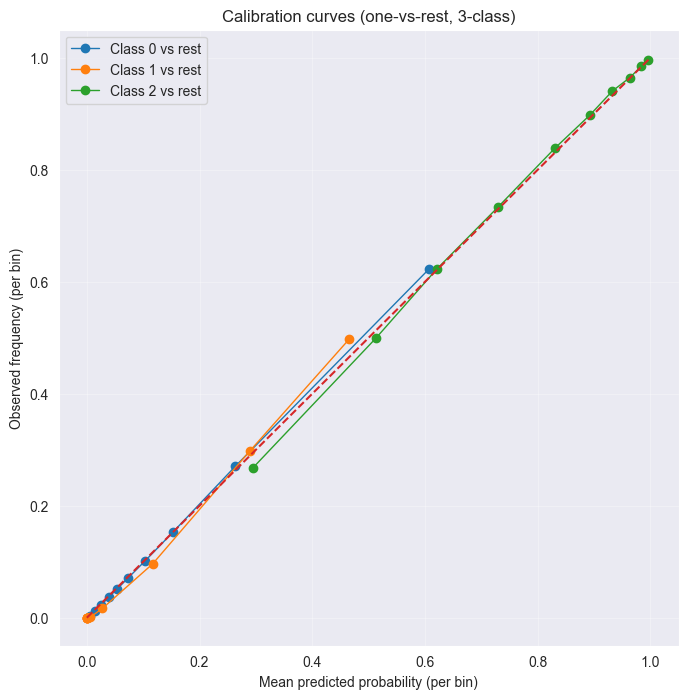

In [18]:
def plot_multiclass_calibration_curves(fitted_pipe, X, y, n_bins=10, strategy="quantile"):
    """
    Multiclass calibration via one-vs-rest curves.
    For each class k: compare predicted P(Y=k) vs observed frequency of Y=k.
    """
    proba = fitted_pipe.predict_proba(X)
    # shape: (n_samples, 3)
    # proba[i,j] = the model’s predicted probability that sample i belongs to class j.


    plt.figure(figsize=(8, 8))

    for k in range(3):  # because the labels are 0/1/2
        y_bin = (y == k).astype(int)  # 1 if class k, else 0

        frac_pos, mean_pred = calibration_curve(
            y_bin,
            proba[:, k],
            n_bins=n_bins,
            strategy=strategy
        )

        plt.plot(mean_pred, frac_pos, marker="o", linewidth=1, label=f"Class {k} vs rest")

    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("Mean predicted probability (per bin)")
    plt.ylabel("Observed frequency (per bin)")
    plt.title("Calibration curves (one-vs-rest, 3-class)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

plot_multiclass_calibration_curves(pipe, X_test, y_test)

--- Threshold selection ---

In [ ]:
default_label = 2
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)
model = XGBClassifier(**final_xgb_params)
model.fit(X_tr, y_tr)

classes = list(model.classes_)
default_idx = classes.index(default_label)

In [ ]:
def predict_with_default_threshold(proba, threshold):
    """
    Rule:
    - if P(default) >= threshold -> predict default
    - else -> argmax among other classes
    """
    other_idx = [i for i, c in enumerate(classes) if c != default_label]
    preds = []
    for p in proba:
        if p[default_idx] >= threshold:
            preds.append(default_label)
        else:
            preds.append(classes[other_idx[np.argmax(p[other_idx])]])
    return np.array(preds)

In [ ]:
def print_eval(y_true, y_pred, title):
    print(f"\n===== {title} =====")
    print("macro-F1:", f1_score(y_true, y_pred, average="macro"))
    print("accuracy:", accuracy_score(y_true, y_pred))
    print("confusion:\n", confusion_matrix(y_true, y_pred, labels=classes))

# -----------------------------
# 3) VAL BEFORE (argmax)
# -----------------------------
pred_val_before = model.predict(X_val)
print_eval(y_val, pred_val_before, "VAL BEFORE (argmax)")

# -----------------------------
# 4) Scan thresholds on VAL (optimize macro-F1)
# -----------------------------
proba_val = model.predict_proba(X_val)

thresholds = np.linspace(0.05, 0.95, 37)  # finer grid
best_t, best_macro_f1 = None, -1

for t in thresholds:
    pred_val_after = predict_with_default_threshold(proba_val, threshold=t)
    macro_f1 = f1_score(y_val, pred_val_after, average="macro")
    if macro_f1 > best_macro_f1:
        best_macro_f1, best_t = macro_f1, t

print("\nBest threshold on VAL:", best_t)
print("Best VAL macro-F1 AFTER:", best_macro_f1)

# Optional: show VAL AFTER metrics at best_t
pred_val_after_best = predict_with_default_threshold(proba_val, threshold=best_t)
print_eval(y_val, pred_val_after_best, f"VAL AFTER (threshold={best_t:.2f})")

# -----------------------------
# 5) FINAL: Train on ALL TRAIN, evaluate on TEST (BEFORE/AFTER)
# -----------------------------
model.fit(X_train, y_train)

# TEST BEFORE
pred_test_before = model.predict(X_test)
print_eval(y_test, pred_test_before, "TEST BEFORE (argmax)")

# TEST AFTER
proba_test = model.predict_proba(X_test)
pred_test_after = predict_with_default_threshold(proba_test, threshold=best_t)
print_eval(y_test, pred_test_after, f"TEST AFTER (threshold={best_t:.2f})")

print("\nClassification report (TEST AFTER):\n")
print(classification_report(y_test, pred_test_after))